In [1]:
import spacy 
import neuralcoref
import re
import pandas as pd 
import string
nlp = spacy.load('en_core_web_lg')
neuralcoref.add_to_pipe(nlp)

import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Entity_sentiment_trainV2.csv', index_col=0)

In [3]:
df_test = pd.read_csv('Entity_sentiment_testV2.csv')

In [4]:
df

,Sentence,Entity,Sentiment
0,The website was very easy to use and my insura...,website,positive
1,The web sight was easy to understand and I got...,web sight,positive
2,Having filled in the application on-line I cou...,point,negative
3,After finding AXA was cheaper than my renewal ...,prices,positive
4,The quote was a reasonable price compared with...,insurances,positive
...,...,...,...
5994,In particular our group have several pre exist...,questions,positive
5995,The gentleman I spoke to came across as bring ...,gentleman,negative
5996,car insurance the conversation with the young ...,car insurance,positive
5997,The AXA website was easy to use and understand...,website,positive


In [5]:
df_test

,Sentence,Entity
0,I telephoned AXA customer service as we had a ...,staff
1,Got the quote on line which was very straightf...,axa
2,Not enough information on insurance details no...,information
3,It was admittedly at 11pm but they DO claim to...,service
4,Good servicewith very little hassleeasy to use...,price
...,...,...
1285,it is time a policy was tailored for the older...,reward
1286,"then, they just removed the itunes credit rewa...",reward
1287,poor cheap stunt to save money and remove reward.,reward
1288,"the rewards programme, which used to be quite ...",reward


In [6]:
def preprocess(sent):
    pre = re.sub('\.', '\. ', sent)
    pre = pre.translate(str.maketrans('', '', string.punctuation))
    pre = pre.lower()
    pre = re.sub('  ', ' ', pre)
    pre = re.sub('  ', ' ', pre)
    pre = re.sub('  ', ' ', pre)
    doc = nlp(pre)
    lemmatized_doc = []
    for token in doc:
        lemmatized_token = token.lemma_
        if lemmatized_token == '-PRON-':
            lemmatized_doc.append(str(token))
        else:
            lemmatized_doc.append(lemmatized_token)
    lemmatized_string = " ".join(lemmatized_doc)
    return lemmatized_string
    
    

In [7]:
df['preprocessed'] = df['Sentence'].apply(lambda x: preprocess(x))

In [8]:
df_test['preprocessed'] = df_test['Sentence'].apply(lambda x: preprocess(x))

In [9]:
def resolve_coref_string(sent):
    doc = nlp(sent)
    resolved = doc._.coref_resolved
    return resolved
    

In [10]:
df['Coreference_resolved'] = df['preprocessed'].apply(lambda x: resolve_coref_string(x))

In [11]:
df_test['Coreference_resolved'] = df_test['preprocessed'].apply(lambda x: resolve_coref_string(x))

In [12]:
#remove oov words
def remove_oov(sent): 
    doc = nlp(sent)
    new_sent = []
    for token in doc:
        if token.is_oov == True:
            None
        else:
            new_sent.append(str(token))
    new_sent_string = " ".join(new_sent)
    return new_sent_string

In [13]:
df['No_oov'] = df['Coreference_resolved'].apply(lambda x: remove_oov(x))

In [14]:
df_test['No_oov'] = df_test['Coreference_resolved'].apply(lambda x: remove_oov(x))

In [15]:
#create labels from preprocessed data
sentiments = df['Sentiment'].to_list()
sentiment_dict = {'positive': 1, 'negative':0}
sentiment_binary = [sentiment_dict.get(item, item) for item in sentiments]
labels = np.array(sentiment_binary)

In [16]:
#create training sentences and testing sentences from preprocessed data
corpus = df['No_oov'].to_list()
corpus_test = df_test['No_oov'].to_list()

In [17]:
#define number of cross-validation sets
kf = StratifiedKFold(n_splits=10)

In [18]:
#train model, predict labels for testing set, and create confusion matrix on validation set
totalsvm = 0
total_svm_conf_matrix = np.zeros((2, 2)) 

for train_index, validation_index in kf.split(corpus,labels):
    X_train = [corpus[i] for i in train_index]
    X_validation = [corpus[i] for i in validation_index]
    y_train, y_validation = labels[train_index], labels[validation_index]
    vectorizer = TfidfVectorizer(min_df=3, sublinear_tf=True, use_idf=True, ngram_range=(1, 2))
    train_corpus_tf_idf = vectorizer.fit_transform(X_train)
    validation_corpus_tf_idf = vectorizer.transform(X_validation)
    test_tfidf = vectorizer.transform(corpus_test)
    
    model_svm = LinearSVC()
    model_svm.fit(train_corpus_tf_idf,y_train)
    result_svm = model_svm.predict(validation_corpus_tf_idf)
    test = model_svm.predict(test_tfidf)
    
    total_svm_conf_matrix = total_svm_conf_matrix + confusion_matrix(y_validation, result_svm)
    totalsvm = totalsvm+sum(y_validation==result_svm)


In [19]:
#convert testing labels back into words, add to testing df, and save to csv file
sent_dict_rev = {v: k for k, v in sentiment_dict.items()}
sentiment_binary_test = [sent_dict_rev.get(item, item) for item in test]
df_test['predicted_values'] = sentiment_binary_test

df_test.to_csv('Predicted_labels_testing_set.csv')

In [20]:
#display confusion matrix (as numpy array)
total_svm_conf_matrix

array([[1573.,  326.],
       [ 285., 3815.]])

In [21]:
#display precision, recall and f1-score
prec_rec_f1 = precision_recall_fscore_support(y_validation, result_svm, average='weighted')
print('Precision: ', prec_rec_f1[0], '\nRecall: ', prec_rec_f1[1], '\nF1-score: ', prec_rec_f1[2])



Precision:  0.9119419446005422 
Recall:  0.9115191986644408 
F1-score:  0.9117050988243415


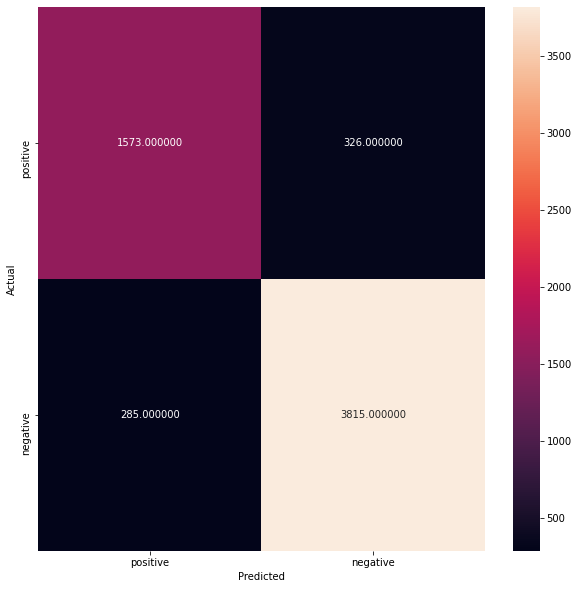

In [22]:
#create and save heatmap for easier visualisation of confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(total_svm_conf_matrix, annot=True, fmt='f',
            xticklabels=sentiment_dict.keys(), yticklabels=sentiment_dict.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix_heatmap.png')
plt.show()